In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import glob
import os
from pathlib import Path
from plaid.evaluation import batch_rmsd_calculation, run_tmalign, RITAPerplexity, batch_rmspd_from_pdb_paths
from plaid.utils import extract_avg_b_factor_per_residue, read_sequences_from_fasta
import numpy as np
import matplotlib.pyplot as plt

sample_dir = Path("/data/lux70/plaid/artifacts/samples/5j007z42/by_length/")
# sample_dir = Path("/data/lux70/plaid/artifacts/samples/by_length/")

# Structure

## PLAID

In [24]:
lengths = [int(x) for x in os.listdir(sample_dir)]
# lengths = np.arange(32, 174, 4)
lengths.sort()
print(lengths)

[32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156, 160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200, 204, 208, 212, 216, 220, 224, 228, 232, 236, 240, 244, 248, 252, 256]


In [31]:
all_stats = {}
import pandas as pd

for l in lengths:
    try:
        tmp = pd.read_csv(sample_dir / str(l) / "designability.csv")
        tmp = tmp.rename({"ccTM":"cctm"},axis=1)
        tmp = tmp.reset_index(drop=True)
        tmp = tmp.drop(['Unnamed: 0'],axis=1)
        all_stats[l] = tmp
    except Exception as e:
        print(e)
        pass
tmp.head()

,pdb_paths,sequences,inverse_generated_pdb_paths,inv_gen_seqs,phantom_generated_pdb_paths,phantom_gen_seqs,plddt,ccrmsd,cctm,designable,...,aromaticity,instability_index,isoelectric_point,gravy,charge_at_pH,ccsr,scsr,alpha_fraction,beta_fraction,dssp_annotation
0,/data/lux70/plaid/artifacts/samples/5j007z42/b...,MNKMLSILRNGLLSEEMAAALLWRRYVDADDSDVSIGPHLTDEVHR...,/data/lux70/plaid/artifacts/samples/5j007z42/b...,MKELEEKLEKGELTEEELLEKLEEKLELLLPEELLLPELLKSPEVK...,/data/lux70/plaid/artifacts/samples/5j007z42/b...,LPLLLLLLLLDGLSPLDVLLLLLLLLELLADPELALLPLLPPELLE...,30.768895,24.168073,0.30717,False,...,0.080078,57.842617,5.553192,-0.090625,-13.121228,0.189453,0.208984,0.263672,0.007812,CHHHHHHHHTTSSCHHHHHHHHHHHHHSSCSSSCCCCGGGGSHHHH...
1,/data/lux70/plaid/artifacts/samples/5j007z42/b...,LDLDPASIEEAWDAAAALAAPIVDFVRAYTTLSVQRTVLRLPGVDE...,/data/lux70/plaid/artifacts/samples/5j007z42/b...,LPLSPELLRLLGRLLLLLLKPLLKLLLKNLFIPILKALLLEVPLEK...,/data/lux70/plaid/artifacts/samples/5j007z42/b...,MEVPEEELEKAAKLREEKLKPKEEEKEKKEKELIEEILEKIPEKPV...,39.948208,9.617121,0.66552,False,...,0.074219,34.953906,5.944188,-0.124805,-7.048275,0.210938,0.197266,0.226562,0.080078,CCCCHHHHHHHHHHHHHHHHHHHHHHHHHTHHHHHHHHHHTTCCCC...
2,/data/lux70/plaid/artifacts/samples/5j007z42/b...,AGPIVKVDKGLIAGRIIPSKSGRSAQVFLGIPFAEAPVGDMRFKHP...,/data/lux70/plaid/artifacts/samples/5j007z42/b...,MGKIVKIKNGEVKGKREETPSGKPIDVFKGIPYAEAPVGDNLFQEP...,/data/lux70/plaid/artifacts/samples/5j007z42/b...,DGPVVTISNGKVKGKYVKGEDGKEREVFLNVPYAEAPIGDRRFQEP...,70.443239,1.761144,0.96462,True,...,0.105469,32.234590,6.866741,-0.013281,-0.391600,0.376953,0.373047,0.255859,0.142578,CCCEEEETTEEEECEEECCTTSCCEEEEEEEECBCCCCGGGTTSCC...
3,/data/lux70/plaid/artifacts/samples/5j007z42/b...,DVLVAGSGSGLTTAAELARAGRSVVVVERLTAHGGTTAFSGAAVGI...,/data/lux70/plaid/artifacts/samples/5j007z42/b...,MWLVVGSGMGLFYAARLAEEGREVTVVEKSPLLGGTTARSSGGLSV...,/data/lux70/plaid/artifacts/samples/5j007z42/b...,MWLVVGSGIGLFYAALLAAEGKEVTVVEKSPYIGGNTARSSGLLLY...,66.613021,3.329832,0.89464,False,...,0.066406,31.609805,5.810730,-0.034961,-11.536610,0.365234,0.382812,0.212891,0.199219,CEEEECSSTHHHHHHHHHHTTCCEEEECSSSSBSHHHHHSCCCEEC...
4,/data/lux70/plaid/artifacts/samples/5j007z42/b...,DIVVVGGGLCGALAALESAKAGKRVLMLEATNHSALGQVSKHGTKI...,/data/lux70/plaid/artifacts/samples/5j007z42/b...,MITVIGAGLAGTLAALEAAKEGKKVLMLEAFDESTIGRTVLLPEGL...,/data/lux70/plaid/artifacts/samples/5j007z42/b...,MVVVVGGGVAGSIAAIRAAEEGKEVTLLEALPESLIGVGSLLNLLL...,50.663183,6.302442,0.77508,False,...,0.099609,35.465273,5.864727,-0.368359,-8.914354,0.281250,0.248047,0.250000,0.177734,CEEEECCSHHHHHHHHHHHHTTCCEEEEESSCGGGTTCSSSSCTTC...


In [32]:
big_df = pd.concat(list(all_stats.values()))
print(big_df.shape)

big_df.head()

(3648, 25)


,pdb_paths,sequences,inverse_generated_pdb_paths,inv_gen_seqs,phantom_generated_pdb_paths,phantom_gen_seqs,plddt,ccrmsd,cctm,designable,...,aromaticity,instability_index,isoelectric_point,gravy,charge_at_pH,ccsr,scsr,alpha_fraction,beta_fraction,dssp_annotation
0,/data/lux70/plaid/artifacts/samples/5j007z42/s...,QRMAGIWADLLGLRRVGVRDSFFELGGDSIMSLQLVERARGAGLPL...,/data/lux70/plaid/artifacts/samples/5j007z42/s...,SELAELLAEILGRERVGEDDDFWALGGDEELGRRLVERARARGIPL...,/data/lux70/plaid/artifacts/samples/5j007z42/s...,SEIEELLAEILGLPEVAPDDDFWELGGDEELGREFVRRARERGIPL...,73.284277,0.092341,0.99887,True,...,0.062500,47.112500,11.698965,0.021875,3.856169,0.437500,0.390625,0.250000,0.000000,CHHHHHHHHHHTCSCCCTTCCTTTTTCCHHHHHHHHHHHHHTTCCC...
1,/data/lux70/plaid/artifacts/samples/5j007z42/s...,GKYQIGGVPDGAKGERLTPEALDYVGLLHRLFSSRRISLLSQREHK...,/data/lux70/plaid/artifacts/samples/5j007z42/s...,AAPAPPPPPPGAPAPALSPAQLALLAALAAVLAATGLPPEALAAAL...,/data/lux70/plaid/artifacts/samples/5j007z42/s...,APPPPAAAPPGAPGAPLSPEELAALAAAAAALAAAGLTPEELAAAL...,50.418323,6.697484,0.57852,False,...,0.062500,34.587500,9.226667,-0.610938,1.945932,0.171875,0.187500,0.312500,0.000000,CCCCCCCCCTTSCCCCCCHHHHHHHHHHHHHHHHTTCCHHHHHHHH...
2,/data/lux70/plaid/artifacts/samples/5j007z42/s...,CVCDGHAERCFIRRLTRDANKAYPETWCIECSHGTMGDYCEKCMPH...,/data/lux70/plaid/artifacts/samples/5j007z42/s...,CDCNGYSDECEVNPVCETPENCTPETRCINCKGNRSGPYCEECKPG...,/data/lux70/plaid/artifacts/samples/5j007z42/s...,CDCNGASTECEVTYPNEDPNNPKPITRCLNCTYGTCGPHCEECCPG...,67.839591,3.705783,0.79266,False,...,0.125000,58.190781,5.436275,-0.657813,-3.044961,0.343750,0.328125,0.265625,0.359375,CCCTTSCSEEEEEEEEEETTEEEEEEEEESCCTTEESTTSCEECTT...
3,/data/lux70/plaid/artifacts/samples/5j007z42/s...,DYYSLLNVPQSASKKEIKTAYRKLALKYHPDKNADNPNAEEKFKNL...,/data/lux70/plaid/artifacts/samples/5j007z42/s...,DHFAILGVPPSASEAEIRAAFERLAAEYHPERRADDPEAAARFARL...,/data/lux70/plaid/artifacts/samples/5j007z42/s...,NPFEILGVSEEATKEEIEEAYKKLAEEYHPEKRKDDPEAQKRYDEI...,84.917634,0.059500,0.99953,True,...,0.109375,37.481250,8.843725,-1.345313,1.850928,0.453125,0.437500,0.140625,0.000000,CHHHHTTCCTTCCHHHHHHHHHHHHHHHCTTTCTTCTTHHHHHHHH...
4,/data/lux70/plaid/artifacts/samples/5j007z42/s...,KKEGIYRHLSGSYARDAYGLYHGEQRIEAAKPISFTMVSMNLFRDQ...,/data/lux70/plaid/artifacts/samples/5j007z42/s...,PSPLPVEELPGPWRRTERGLWEGERLLPWATPGEWRLVGPGRWVDT...,/data/lux70/plaid/artifacts/samples/5j007z42/s...,SNPAPLKKLKGNYYVDKDGVYYGDKKIEEFNPENVVLIDDNTLVDK...,44.938960,1.528275,0.80463,True,...,0.109375,31.454688,8.264025,-0.853125,1.031109,0.296875,0.265625,0.265625,0.390625,CCCCCCEEETTTEEEETTEEEETTEEETTCCSSCEEEEETTEEEEC...


Text(0.5, 1.0, 'scTM')

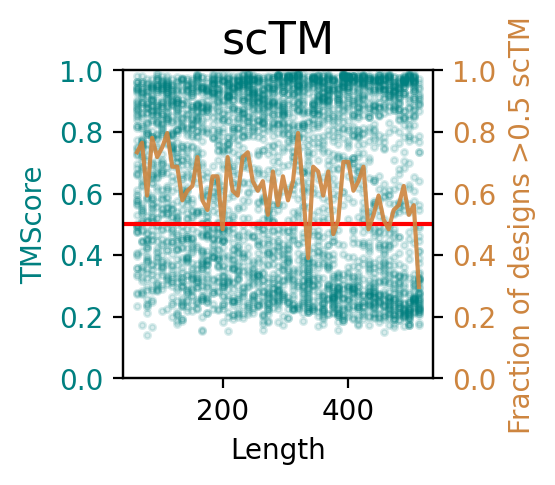

In [35]:
metric = "sctm"

fig,ax = plt.subplots(1,1,figsize=(2,2), dpi=200)

designable = []

for k, v in all_stats.items():
    data = v[metric]
    designable.append((np.array(data) > 0.5).sum() / len(data))
    ax.scatter([int(k) * 2] * len(data), data, s=5, c="teal",alpha=0.15)
    
ax.set_ylim(0,1)
ax.axhline(0.5, c='red')
ax.set_ylabel("TMScore", c='teal')
ax.tick_params(axis='y', labelcolor='teal')
ax.set_xlabel("Length")

scale = np.array(lengths) * 2

ax_ = ax.twinx()
ax_.plot(scale, designable, c="peru", alpha=0.9)
ax_.set_ylim(0, 1)
ax_.set_ylabel("Fraction of designs >0.5 scTM", c='peru')
ax_.tick_params(axis='y', labelcolor='peru')


plt.title("scTM", fontsize=16)

Text(0.5, 1.0, 'ccTM')

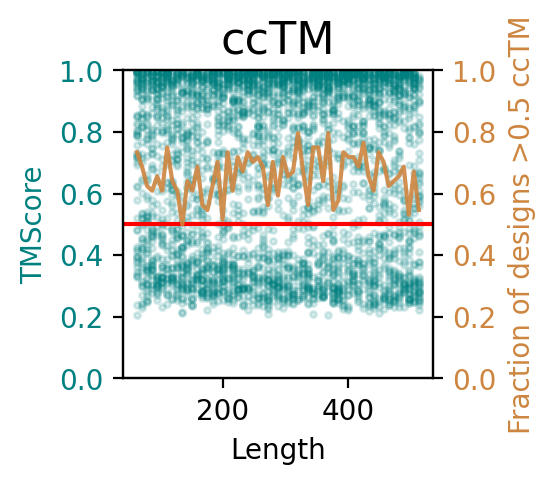

In [36]:
metric = "cctm"

fig,ax = plt.subplots(1,1,figsize=(2,2), dpi=200)

designable = []

for k, v in all_stats.items():
    data = v[metric]
    designable.append((np.array(data) > 0.5).sum() / len(data))
    ax.scatter([int(k) * 2] * len(data), data, s=5, c="teal",alpha=0.15)
    
ax.set_ylim(0,1)
ax.axhline(0.5, c='red')
ax.set_ylabel("TMScore", c='teal')
ax.tick_params(axis='y', labelcolor='teal')
ax.set_xlabel("Length")

scale = np.array(lengths) * 2

ax_ = ax.twinx()
ax_.plot(scale, designable, c="peru",alpha=0.9)
ax_.set_ylim(0, 1)
ax_.set_ylabel("Fraction of designs >0.5 ccTM", c='peru')
ax_.tick_params(axis='y', labelcolor='peru')


plt.title("ccTM", fontsize=16)

Text(0.5, 1.0, 'scRMSD')

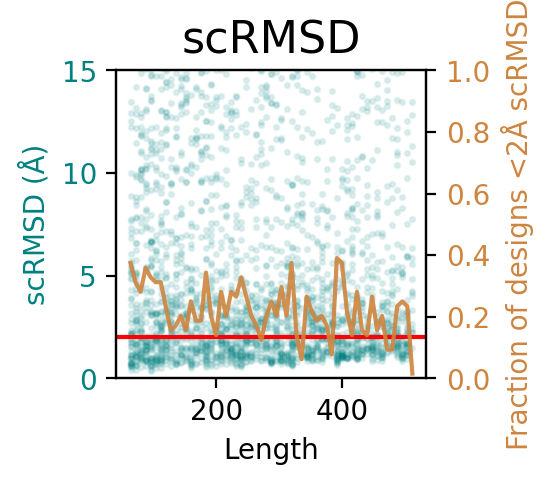

In [40]:
metric = "scrmsd"

fig,ax = plt.subplots(1,1,figsize=(2,2), dpi=200)

designable = []

for k, v in all_stats.items():
    data = v[metric]
    designable.append((np.array(data) < 2).sum() / len(data))
    ax.scatter([int(k) * 2] * len(data), data, s=3, c="teal",alpha=0.1)
    
    
ax.set_ylim(0,15)
ax.axhline(2, c='red')
ax.set_ylabel("scRMSD (Å)", c='teal')
ax.tick_params(axis='y', labelcolor='teal')

ax.set_xlabel("Length")

scale = np.array(lengths) * 2

ax_ = ax.twinx()
ax_.plot(scale, designable, c="peru",alpha=0.9)
ax_.set_ylim(0, 1)
ax_.set_ylabel("Fraction of designs <2Å scRMSD", c='peru')
ax_.tick_params(axis='y', labelcolor='peru')

plt.title("scRMSD", fontsize=16)

Text(0.5, 1.0, 'ccRMSD')

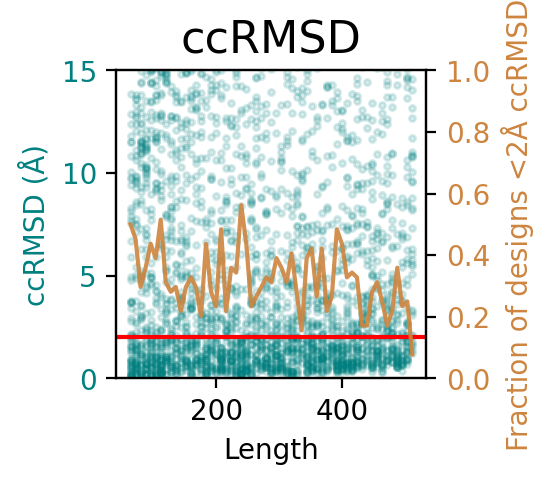

In [38]:
metric = "ccrmsd"

fig,ax = plt.subplots(1,1,figsize=(2,2), dpi=200)

designable = []

for k, v in all_stats.items():
    data = v[metric]
    designable.append((np.array(data) < 2).sum() / len(data))
    ax.scatter([int(k) * 2] * len(data), data, s=5, c="teal",alpha=0.15)
    
ax.set_ylim(0,15)
ax.axhline(2, c='red')
ax.set_ylabel("ccRMSD (Å)", c='teal')
ax.tick_params(axis='y', labelcolor='teal')

ax.set_xlabel("Length")

scale = np.array(lengths) * 2

ax_ = ax.twinx()
ax_.plot(scale, designable, c="peru",alpha=0.9)
ax_.set_ylim(0, 1)
ax_.set_ylabel("Fraction of designs <2Å ccRMSD", c='peru')
ax_.tick_params(axis='y', labelcolor='peru')

plt.title("ccRMSD", fontsize=16)

In [ ]:
metric = "perplexity"

fig,ax = plt.subplots(1,1,figsize=(2,2), dpi=200)

designable = []

for k, v in all_stats.items():
    data = v[metric]
    designable.append((np.array(data) < 2).sum() / len(data))
    ax.scatter([int(k) * 2] * len(data), data, s=5, c="teal",alpha=0.15)
    
# ax.set_ylim(0,15)
# ax.axhline(2, c='red')
# ax.set_ylabel("ccRMSD (Å)", c='teal')
# ax.tick_params(axis='y', labelcolor='teal')

ax.set_xlabel("Length")

scale = np.array(lengths) * 2

ax_ = ax.twinx()
ax_.plot(scale, designable, c="peru",alpha=0.9)
ax_.set_ylim(0, 1)
ax_.set_ylabel("Fraction of designs <2Å ccRMSD", c='peru')
ax_.tick_params(axis='y', labelcolor='peru')

plt.title("ccRMSD", fontsize=16)